In [ ]:
from google.colab import drive



drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install kaggle


In [ ]:
! mkdir -p ~/.kaggle/

! mv /content/kaggle.json ~/.kaggle/

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d darshue/extracted-images

100% 3.40G/3.40G [02:55<00:00, 20.7MB/s]
100% 3.40G/3.40G [02:55<00:00, 20.8MB/s]


In [ ]:
import zipfile
def unzip_folder(zip_file_path, extract_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)


zip_file_path = '/content/extracted-images.zip'
extract_folder = '/content/Datasets_Ovarian/Image_Data/'

unzip_folder(zip_file_path, extract_folder)


In [ ]:
import os
import random

def delete_excess_images(folder_path, max_images=2123):
    try:
        while True:
            image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
            num_images = len(image_files)

            if num_images <= max_images:
                print(f"Total images in folder: {num_images}")
                break

            random.shuffle(image_files)
            file_to_delete = image_files.pop()
            file_path = os.path.join(folder_path, file_to_delete)
            os.remove(file_path)



    except Exception as e:
        print(f"Error occurred: {str(e)}")


folder_path5 = '/content/Datasets_Ovarian/Image_Data/train/EC'
folder_path6 = '/content/Datasets_Ovarian/Image_Data/train/CC'
folder_path7 = '/content/Datasets_Ovarian/Image_Data/train/HGSC'
folder_path8 = '/content/Datasets_Ovarian/Image_Data/train/LGSC'
folder_path9 = '/content/Datasets_Ovarian/Image_Data/train/MC'


delete_excess_images(folder_path5, max_images=2033)
delete_excess_images(folder_path6, max_images=2005)
delete_excess_images(folder_path7, max_images=2022)
delete_excess_images(folder_path8, max_images=2020)
delete_excess_images(folder_path9, max_images=2070)


# folder_path5d = '/content/Datasets_Ovarian/Image_Data/Test_Images/EC'
# folder_path6d = '/content/Datasets_Ovarian/Image_Data/Test_Images/CC'
# folder_path7d = '/content/Datasets_Ovarian/Image_Data/Test_Images/HGSC'
# folder_path8d = '/content/Datasets_Ovarian/Image_Data/Test_Images/LGSC'
# folder_path9d = '/content/Datasets_Ovarian/Image_Data/Test_Images/MC'


# delete_excess_images(folder_path5d, max_images=266)
# delete_excess_images(folder_path6d, max_images=293)
# delete_excess_images(folder_path7d, max_images=300)
# delete_excess_images(folder_path8d, max_images=287)
# delete_excess_images(folder_path9d, max_images=333)


Total images in folder: 2033
Total images in folder: 2005
Total images in folder: 2022
Total images in folder: 2020
Total images in folder: 2070


In [ ]:
# Training InceptionResnetV2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

batch_size = 32
img_height = 256
img_width = 256
data_dir='/content/Datasets_Ovarian/Image_Data/train'  # 124,124   bs - 8

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory


data_augmentation = tf.keras.Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomContrast(0.2),
])


train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))# map function to run data augumentation on all images

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 12571 files belonging to 5 classes.
Using 10057 files for training.
Found 12571 files belonging to 5 classes.
Using 2514 files for validation.


In [ ]:
class_names = ['CC','MC','HGSC','LGSC','EC']
print(class_names)

['CC', 'MC', 'HGSC', 'LGSC', 'EC']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.29205942 0.93783647


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras import regularizers

num_classes = len(class_names)
base_model = InceptionResNetV2(weights=None, include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


315/315 [==============================] - 666s 2s/step - loss: 1.6190 - accuracy: 0.3531 - val_loss: 58.2946 - val_accuracy: 0.1917
Epoch 2/50
315/315 [==============================] - 87s 277ms/step - loss: 1.2657 - accuracy: 0.4879 - val_loss: 93.4209 - val_accuracy: 0.1842
Epoch 3/50
315/315 [==============================] - 87s 277ms/step - loss: 1.0698 - accuracy: 0.5926 - val_loss: 2.6426 - val_accuracy: 0.2251
Epoch 4/50
315/315 [==============================] - 87s 278ms/step - loss: 0.9823 - accuracy: 0.6304 - val_loss: 2.6909 - val_accuracy: 0.4181
Epoch 5/50
315/315 [==============================] - 87s 278ms/step - loss: 0.9986 - accuracy: 0.6177 - val_loss: 6.0161 - val_accuracy: 0.2490
Epoch 6/50
315/315 [==============================] - 87s 278ms/step - loss: 0.8707 - accuracy: 0.6753 - val_loss: 11.1585 - val_accuracy: 0.2009
Epoch 7/50
315/315 [==============================] - 87s 278ms/step - loss: 0.8687 - accuracy: 0.6741 - val_loss: 1.5044 - val_accuracy: 0.

In [ ]:
model.save('/content/Inception_data_ovarian/ovarian_InceptionResNetV2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


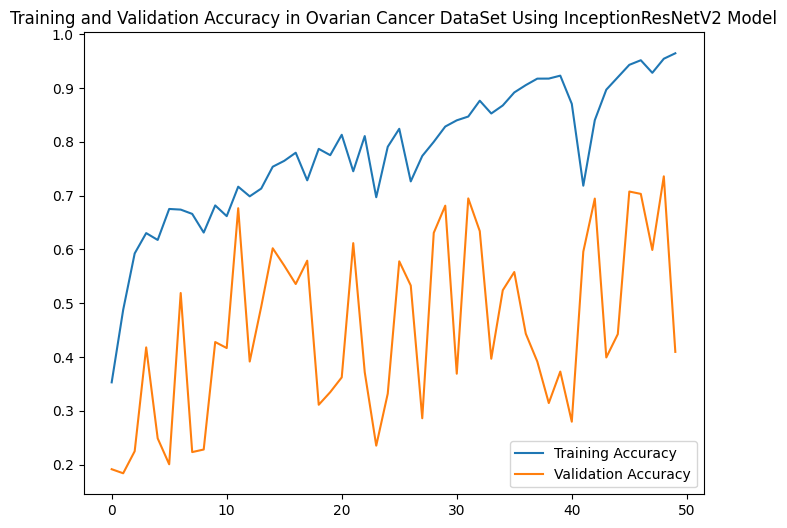

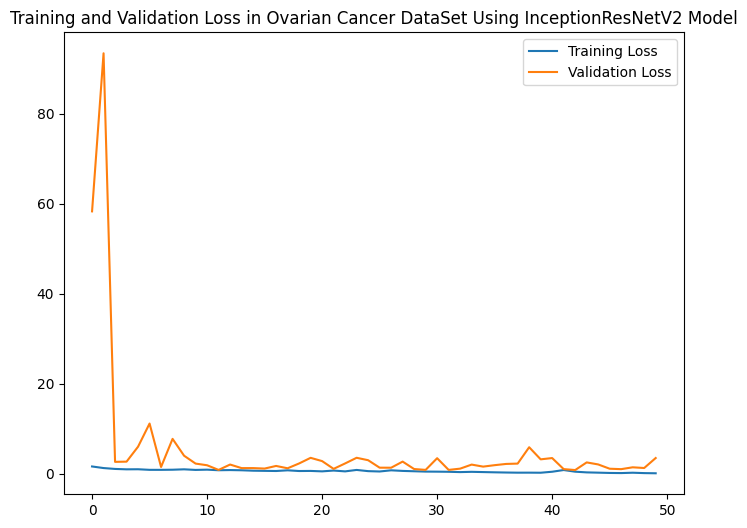

79/79 [==============================] - 6s 82ms/step


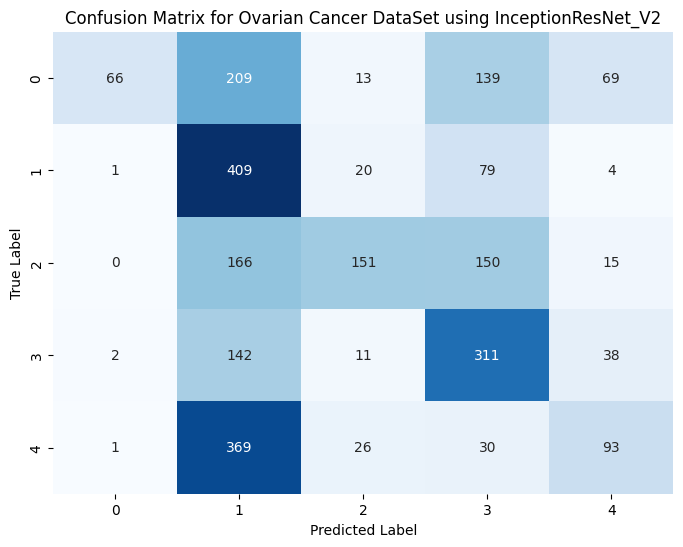

Accuracy: 0.40970564836913287
Precision: 0.5610497383479498
Recall: 0.4079735446204117
F1 Score: 0.3760094828690178
MCC: 0.29054563851771414


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy in Ovarian Cancer DataSet Using InceptionResNetV2 Model')

plt.savefig('/content/Inception_data_ovarian/Training_Val_Acc_ovarian_cancer.png')

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss in Ovarian Cancer DataSet Using InceptionResNetV2 Model')
plt.savefig('/content/Inception_data_ovarian/Training_Val_loss_ovarian_cancer.png')
plt.show()


predictions = model.predict(val_ds)

true_labels = []
for images, labels in val_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
mcc = matthews_corrcoef(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ovarian Cancer DataSet using InceptionResNet_V2')
plt.savefig('/content/Inception_data_ovarian/Ovarian_InceptionResnetV2_confusion_matrix.png')
plt.show()


# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC:", mcc)

import csv

file_path = '/content/Inception_data_ovarian/IP_evaluation_metrics.csv'

evaluation_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC': mcc
}

with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=evaluation_metrics.keys())
    writer.writeheader()
    writer.writerow(evaluation_metrics)


In [ ]:
# image Echancement

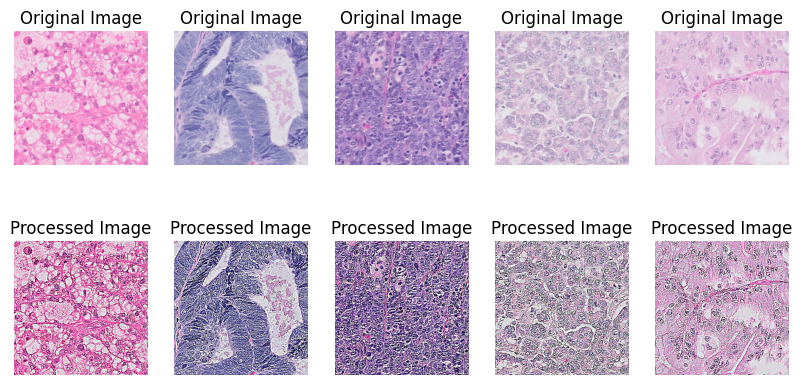

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_images(image_paths, resize_dim=(256, 256), alpha=1.5, beta=0, gamma=1.5):
    processed_images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, resize_dim)
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        sharpened_image = cv2.filter2D(resized_image, -1, kernel)
        gamma_corrected_image = np.clip(((sharpened_image / 255.0) ** gamma) * 255.0, 0, 255).astype(np.uint8)

        processed_images.append(gamma_corrected_image)

    return processed_images

image_paths = ['/content/Datasets_Ovarian/Image_Data/train/CC/11263_1_10_10_500.jpg',
               '/content/Datasets_Ovarian/Image_Data/train/EC/10246_1_10_27_500.jpg',
               '/content/Datasets_Ovarian/Image_Data/train/HGSC/10143_1_15_36_500.jpg',
               '/content/Datasets_Ovarian/Image_Data/train/LGSC/10252_1_29_22_500.jpg',
               '/content/Datasets_Ovarian/Image_Data/train/MC/21445_0_21_23_500.jpg']
processed_images = process_images(image_paths)

fig, axes = plt.subplots(2, len(image_paths), figsize=(10, 5))

for i, image_path in enumerate(image_paths):
    original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    processed_image = cv2.cvtColor(processed_images[i], cv2.COLOR_BGR2RGB)

    axes[0, i].imshow(original_image)
    axes[0, i].set_title('Original Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(processed_image)
    axes[1, i].set_title('Processed Image')
    axes[1, i].axis('off')

plt.show()


In [ ]:
import os
import cv2
import numpy as np
from multiprocessing import Pool



kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

def process_image(image_path,gamma=1.5):
    image = cv2.imread(image_path)
    sharpened_image = cv2.filter2D(image, -1, kernel)
    gamma_corrected_image = np.clip(((sharpened_image / 255.0) ** gamma) * 255.0, 0, 255).astype(np.uint8)
    cv2.imwrite(image_path, gamma_corrected_image)

if __name__ == '__main__':
    directory = '/content/Datasets_Ovarian/Image_Data/train'

    image_paths = []
    for class_folder in os.listdir(directory):
        class_folder_path = os.path.join(directory, class_folder)
        for filename in os.listdir(class_folder_path):
            image_paths.append(os.path.join(class_folder_path, filename))

    with Pool(processes=32) as pool:
        pool.map(process_image, image_paths)


In [ ]:
#DenseNet Model Training

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

batch_size = 32
img_height = 256
img_width = 256
data_dir='/content/Datasets_Ovarian/Image_Data/train'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory


data_augmentation = tf.keras.Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomContrast(0.2),
])


train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10150 files belonging to 5 classes.
Using 8120 files for training.
Found 10150 files belonging to 5 classes.
Using 2030 files for validation.


In [ ]:
class_names = ['CC','MC','HGSC','LGSC','EC']
print(class_names)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

['CC', 'MC', 'HGSC', 'LGSC', 'EC']
0.19830644 0.9701147


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization

num_classes = len(class_names)
base_model1 = Xception(weights=None, include_top=False, input_shape=(img_height, img_width, 3))
base_model1.trainable = True

model1 = Sequential([
    base_model1,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=50
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


254/254 [==============================] - 524s 2s/step - loss: 1.6330 - accuracy: 0.3654 - val_loss: 1.7078 - val_accuracy: 0.2296
Epoch 2/50
254/254 [==============================] - 49s 195ms/step - loss: 1.4424 - accuracy: 0.4009 - val_loss: 1.5826 - val_accuracy: 0.3222
Epoch 3/50
254/254 [==============================] - 49s 195ms/step - loss: 1.2675 - accuracy: 0.4724 - val_loss: 1.7975 - val_accuracy: 0.3227
Epoch 4/50
254/254 [==============================] - 49s 195ms/step - loss: 1.1649 - accuracy: 0.5388 - val_loss: 8.9363 - val_accuracy: 0.2389
Epoch 5/50
254/254 [==============================] - 49s 195ms/step - loss: 1.1154 - accuracy: 0.5562 - val_loss: 4.5274 - val_accuracy: 0.2330
Epoch 6/50
254/254 [==============================] - 49s 195ms/step - loss: 1.0188 - accuracy: 0.6106 - val_loss: 10.1766 - val_accuracy: 0.2044
Epoch 7/50
254/254 [==============================] - 49s 195ms/step - loss: 0.9997 - accuracy: 0.6198 - val_loss: 3.6637 - val_accuracy: 0.27

In [ ]:
model1.save('/content/Xception_data_ovarian/ovarian_Xception.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


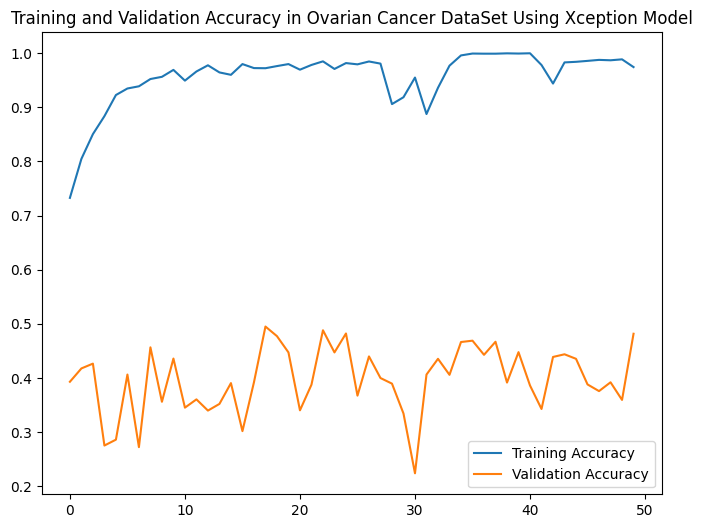

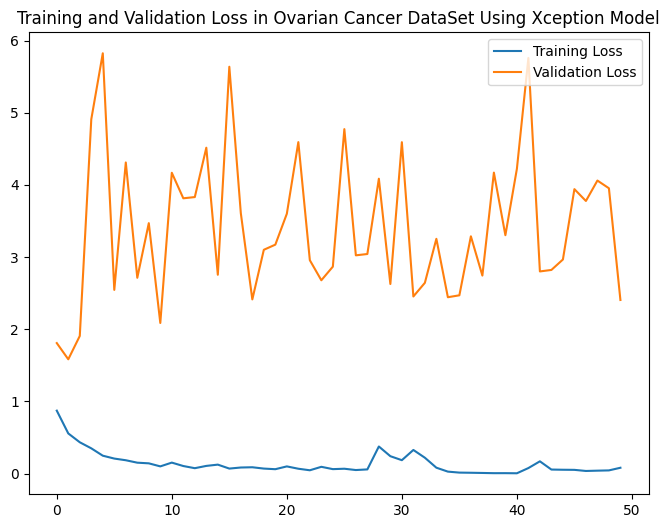

64/64 [==============================] - 3s 54ms/step


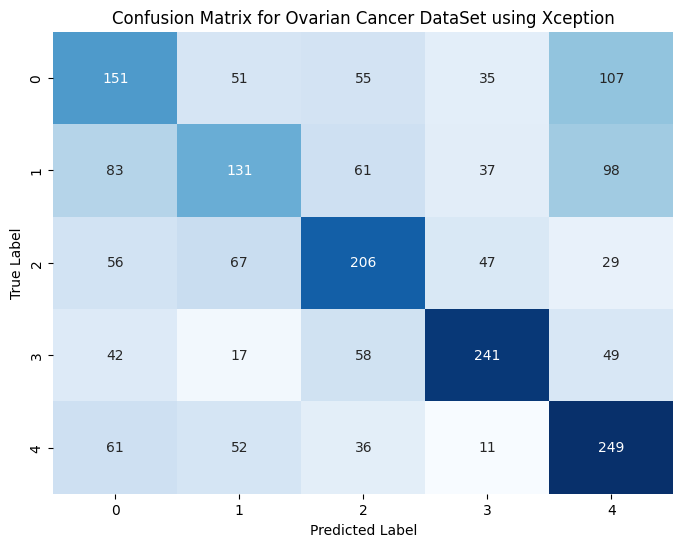

Accuracy: 0.48177339901477834
Precision: 0.4818013423830908
Recall: 0.48150796676932517
F1 Score: 0.4783583572010864
MCC: 0.35354818591333426


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy in Ovarian Cancer DataSet Using Xception Model')

plt.savefig('/content/Xception_data_ovarian/Training_Val_Acc_ovarian_cancer.png')

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss in Ovarian Cancer DataSet Using Xception Model')
plt.savefig('/content/Xception_data_ovarian/Training_Val_loss_ovarian_cancer.png')
plt.show()


predictions = model1.predict(val_ds)

true_labels = []
for images, labels in val_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
mcc = matthews_corrcoef(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ovarian Cancer DataSet using Xception')
plt.savefig('/content/Xception_data_ovarian/Ovarian_Xception_confusion_matrix.png')
plt.show()

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC:", mcc)

import csv

file_path = '/content/Xception_data_ovarian/Rn_evaluation_metrics.csv'

evaluation_metrics = {
    'Accuracy-Efficient': accuracy,
    'Precision-Efficient': precision,
    'Recall-Efficient': recall,
    'F1 Score-Efficient': f1,
    'MCC-Efficient': mcc
}

with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=evaluation_metrics.keys())
    writer.writeheader()
    writer.writerow(evaluation_metrics)


In [ ]:
# MobileNet

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

batch_size = 32
img_height = 256
img_width = 256
data_dir='/content/Datasets_Ovarian/Image_Data/train'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory


data_augmentation = tf.keras.Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomContrast(0.2),
])


train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10150 files belonging to 5 classes.
Using 8120 files for training.
Found 10150 files belonging to 5 classes.
Using 2030 files for validation.


In [ ]:
class_names = ['CC','MC','HGSC','LGSC','EC']
print(class_names)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

['CC', 'MC', 'HGSC', 'LGSC', 'EC']
0.0 1.0


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization

num_classes = len(class_names)
base_model2 = MobileNet(weights=None, include_top=False, input_shape=(img_height, img_width, 3))
base_model2.trainable = True

model2 = Sequential([
    base_model2,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=50
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


254/254 [==============================] - 471s 2s/step - loss: 1.7964 - accuracy: 0.2861 - val_loss: 1.6273 - val_accuracy: 0.2020
Epoch 2/50
254/254 [==============================] - 38s 151ms/step - loss: 1.4415 - accuracy: 0.3909 - val_loss: 1.8197 - val_accuracy: 0.2015
Epoch 3/50
254/254 [==============================] - 38s 150ms/step - loss: 1.3094 - accuracy: 0.4499 - val_loss: 4.5126 - val_accuracy: 0.2010
Epoch 4/50
254/254 [==============================] - 38s 150ms/step - loss: 1.1938 - accuracy: 0.5091 - val_loss: 2.3527 - val_accuracy: 0.2094
Epoch 5/50
254/254 [==============================] - 38s 150ms/step - loss: 1.1207 - accuracy: 0.5562 - val_loss: 2.6445 - val_accuracy: 0.2212
Epoch 6/50
254/254 [==============================] - 38s 150ms/step - loss: 1.0616 - accuracy: 0.5862 - val_loss: 4.9858 - val_accuracy: 0.2044
Epoch 7/50
254/254 [==============================] - 38s 151ms/step - loss: 1.0499 - accuracy: 0.5995 - val_loss: 2.3383 - val_accuracy: 0.233

In [ ]:
model2.save('/content/MobileNet_data_ovarian/ovarian_MobileNetV2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


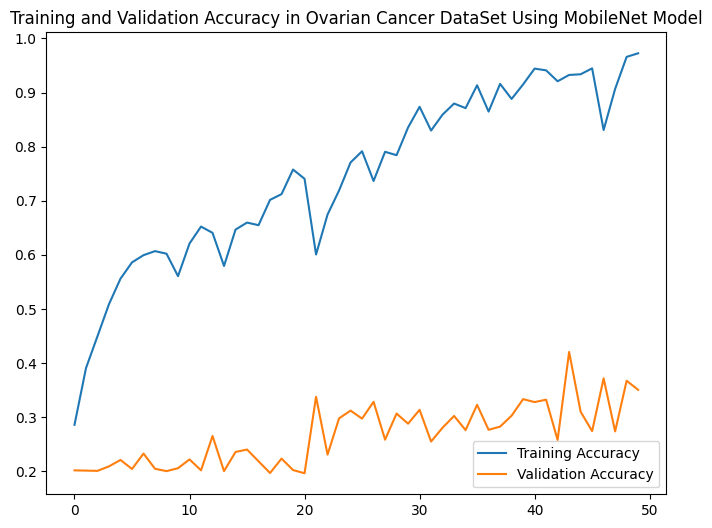

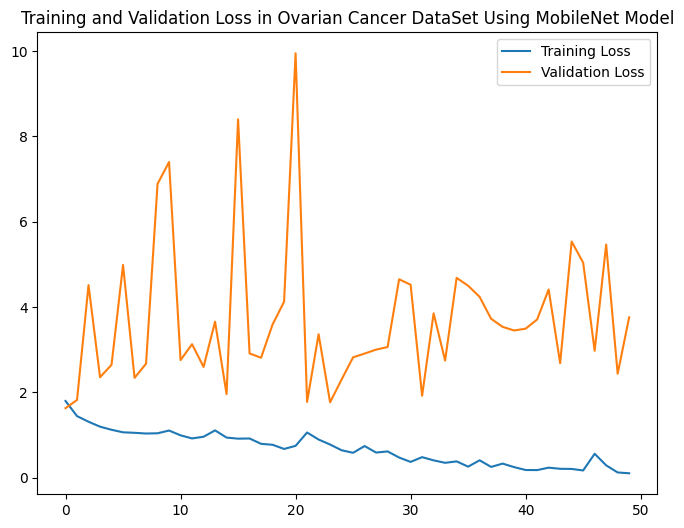

64/64 [==============================] - 3s 42ms/step


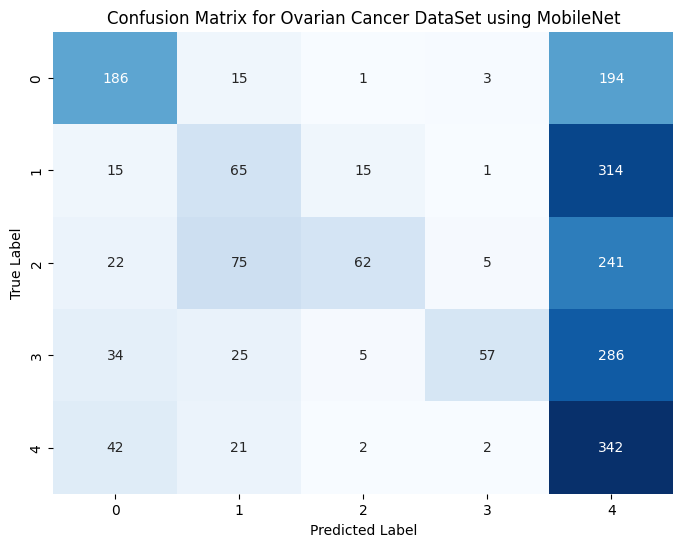

Accuracy: 0.35073891625615766
Precision: 0.5522939470135715
Recall: 0.35080467555456385
F1 Score: 0.3243514389478281
MCC: 0.23596343359266853


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy in Ovarian Cancer DataSet Using MobileNet Model')

plt.savefig('/content/MobileNet_data_ovarian/Training_Val_Acc_ovarian_cancer.png')

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss in Ovarian Cancer DataSet Using MobileNet Model')
plt.savefig('/content/MobileNet_data_ovarian/Training_Val_loss_ovarian_cancer.png')
plt.show()


predictions = model2.predict(val_ds)

true_labels = []
for images, labels in val_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
mcc = matthews_corrcoef(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ovarian Cancer DataSet using MobileNet')
plt.savefig('/content/MobileNet_data_ovarian/Ovarian_MobileNet_confusion_matrix.png')
plt.show()

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC:", mcc)

import csv

file_path = '/content/MobileNet_data_ovarian/Mv_evaluation_metrics.csv'

evaluation_metrics = {
    'Accuracy-Efficient': accuracy,
    'Precision-Efficient': precision,
    'Recall-Efficient': recall,
    'F1 Score-Efficient': f1,
    'MCC-Efficient': mcc
}

with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=evaluation_metrics.keys())
    writer.writeheader()
    writer.writerow(evaluation_metrics)


In [ ]:
#Yolo Model

In [1]:
import os
HOME = os.getcwd()
print(HOME)
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/225.8 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image
import os
import shutil
import random

def split_images_into_folders(source_folder, destination_folder, split_ratios=(0.7, 0.15, 0.15)):
    class_folders = os.listdir(source_folder)

    for class_folder in class_folders:
        os.makedirs(os.path.join(destination_folder, 'train', class_folder), exist_ok=True)# makedirs- to make directory
        os.makedirs(os.path.join(destination_folder, 'test', class_folder), exist_ok=True)
        os.makedirs(os.path.join(destination_folder, 'val', class_folder), exist_ok=True)

        class_images = os.listdir(os.path.join(source_folder, class_folder))
        random.shuffle(class_images)

        total_images = len(class_images)
        train_count = int(total_images * split_ratios[0])
        test_count = int(total_images * split_ratios[1])
        val_count = total_images - train_count - test_count
        for img in class_images[:train_count]:
            src = os.path.join(source_folder, class_folder, img)
            dst = os.path.join(destination_folder, 'train', class_folder, img)
            shutil.copyfile(src, dst)

        for img in class_images[train_count:train_count+test_count]:
            src = os.path.join(source_folder, class_folder, img)
            dst = os.path.join(destination_folder, 'test', class_folder, img)
            shutil.copyfile(src, dst)

        for img in class_images[train_count+test_count:]:
            src = os.path.join(source_folder, class_folder, img)
            dst = os.path.join(destination_folder, 'val', class_folder, img)
            shutil.copyfile(src, dst)

if __name__ == "__main__":
    source_folder = '/content/Datasets_Ovarian/Image_Data/train'
    destination_folder = '/content/Datasets_Ovarian/Image_Data/train_yolo_format'
    split_images_into_folders(source_folder, destination_folder)


# dataset={
#     train-{1,2,3,4,5}
#     test-{1,2,3,4,5}
#     val-{1,2,3,4,5}
# }

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m-cls.yaml')
model = YOLO('yolov8m-cls.pt')
model = YOLO('yolov8m-cls.yaml').load('yolov8m-cls.pt')

results = model.train(data='/content/Datasets_Ovarian/Image_Data/train_yolo_format', epochs=50, imgsz=256)

YOLOv8m-cls summary: 141 layers, 17053336 parameters, 17053336 gradients, 42.9 GFLOPs


100%|██████████| 32.7M/32.7M [00:00<00:00, 439MB/s]


YOLOv8m-cls summary: 141 layers, 17053336 parameters, 17053336 gradients, 42.9 GFLOPs
Transferred 230/230 items from pretrained weights
Ultralytics YOLOv8.1.15 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8m-cls.yaml, data=/content/Datasets_Ovarian/Image_Data/train_yolo_format, epochs=50, time=None, patience=50, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fa

100%|██████████| 6.23M/6.23M [00:00<00:00, 309MB/s]


AMP: checks passed ✅


train: Scanning /content/Datasets_Ovarian/Image_Data/train_yolo_format/train... 7104 images, 0 corrupt: 100%|██████████| 7104/7104 [00:02<00:00, 2689.79it/s]

train: New cache created: /content/Datasets_Ovarian/Image_Data/train_yolo_format/train.cache



val: Scanning /content/Datasets_Ovarian/Image_Data/train_yolo_format/val... 1526 images, 0 corrupt: 100%|██████████| 1526/1526 [00:00<00:00, 2842.82it/s]

val: New cache created: /content/Datasets_Ovarian/Image_Data/train_yolo_format/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs/classify/train
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50      1.15G      1.625         16        256:   6%|▌         | 27/444 [00:03<00:33, 12.48it/s]

       1/50      1.15G      1.607         16        256:  13%|█▎        | 57/444 [00:05<00:29, 13.03it/s]
100%|██████████| 755k/755k [00:00<00:00, 84.8MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.18it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 13.33it/s]

                   all      0.836          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.62it/s]

                   all      0.879          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.30it/s]

                   all      0.874          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.00it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.95it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.92it/s]

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.22it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.70it/s]


                   all      0.933          1

      Epoch    GPU_mem       loss  Instances       Size


      10/50      1.15G     0.3177         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.95it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      1.13G     0.2879         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.72it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.14G      0.274         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.14it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.13G     0.2758         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.24it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.14G     0.2385         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.90it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.14G     0.2248         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.11it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.14G     0.2328         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.06it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.14G     0.2127         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.49it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.14G     0.2003         16        256: 100%|██████████| 444/444 [00:27<00:00, 16.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.79it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.13G     0.2018         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.34it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      1.13G     0.1866         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.61it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      1.15G     0.1632         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.66it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      1.13G     0.1623         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.28it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      1.13G     0.1631         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.27it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      1.13G     0.1536         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.78it/s]


                   all      0.965          1

      Epoch    GPU_mem       loss  Instances       Size


      25/50      1.15G     0.1428         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.73it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      1.13G     0.1413         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 14.63it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      1.13G      0.125         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.57it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      1.14G     0.1328         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.87it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      1.15G     0.1258         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.08it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.13G     0.1256         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 14.50it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.14G     0.1055         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.28it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      1.13G     0.1011         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.65it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.13G    0.09157         16        256: 100%|██████████| 444/444 [00:28<00:00, 15.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.34it/s]


                   all      0.972          1

      Epoch    GPU_mem       loss  Instances       Size


      34/50      1.13G    0.08369         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.54it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      1.13G    0.09353         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.52it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      1.15G    0.09675         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.23it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      1.14G    0.07741         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.63it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      1.13G    0.07521         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.63it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      1.14G    0.07182         16        256: 100%|██████████| 444/444 [00:27<00:00, 16.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.64it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      1.15G    0.06824         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.10it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      1.15G    0.07319         16        256: 100%|██████████| 444/444 [00:27<00:00, 16.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.29it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      1.14G    0.05841         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.41it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      1.13G    0.06036         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.07it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      1.13G     0.0642         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.71it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      1.14G    0.05694         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.44it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      1.13G    0.05478         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.96it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      1.15G    0.05213         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 17.02it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      1.15G    0.05076         16        256: 100%|██████████| 444/444 [00:26<00:00, 16.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.98it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      1.13G    0.04941         16        256: 100%|██████████| 444/444 [00:27<00:00, 16.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:02<00:00, 16.47it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      1.14G    0.04398         16        256: 100%|██████████| 444/444 [00:27<00:00, 16.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 15.71it/s]

                   all       0.98          1



50 epochs completed in 0.435 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 31.7MB
Optimizer stripped from runs/classify/train/weights/best.pt, 31.7MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.1.15 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15769061 parameters, 0 gradients, 41.6 GFLOPs
train: /content/Datasets_Ovarian/Image_Data/train_yolo_format/train... found 7104 images in 5 classes ✅ 
val: /content/Datasets_Ovarian/Image_Data/train_yolo_format/val... found 1526 images in 5 classes ✅ 
test: /content/Datasets_Ovarian/Image_Data/train_yolo_format/test... found 1520 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 48/48 [00:03<00:00, 13.43it/s]


                   all      0.981          1
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


In [ ]:
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef

class_dict = {'CC':0,'EC':1,'HGSC':2,'LGSC':3,'MC':4}

true_labels = []
predicted_labels = []

def get_predicted_labels(image_path):

    model = YOLO('yolov8n-cls.pt')
    model = YOLO('/content/runs/classify/train/weights/best.pt')
    results = model(image_path)
    probs=results[0].probs
    return int(probs.top1)


data_dir = '/content/Datasets_Ovarian/Image_Data/train_yolo_format/val'

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        class_label = class_dict.get(class_name, -1)
        if class_label != -1:
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                true_labels.append(class_label)
                predicted_label = get_predicted_labels(image_path)
                predicted_labels.append(predicted_label)




image 1/1 /content/Datasets_Ovarian/Image_Data/train_yolo_format/val/HGSC/39255_1_38_32_500.jpg: 256x256 HGSC 1.00, MC 0.00, EC 0.00, LGSC 0.00, CC 0.00, 6.5ms
Speed: 13.0ms preprocess, 6.5ms inference, 0.2ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /content/Datasets_Ovarian/Image_Data/train_yolo_format/val/HGSC/20316_3_22_4_500.jpg: 256x256 HGSC 0.99, CC 0.00, EC 0.00, MC 0.00, LGSC 0.00, 6.5ms
Speed: 4.7ms preprocess, 6.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /content/Datasets_Ovarian/Image_Data/train_yolo_format/val/HGSC/27950_1_28_14_500.jpg: 256x256 HGSC 1.00, EC 0.00, CC 0.00, LGSC 0.00, MC 0.00, 6.5ms
Speed: 4.7ms preprocess, 6.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /content/Datasets_Ovarian/Image_Data/train_yolo_format/val/HGSC/37655_2_32_30_500.jpg: 256x256 HGSC 1.00, EC 0.00, CC 0.00, LGSC 0.00, MC 0.00, 6.5ms
Speed: 4.4ms preprocess, 6.5ms inference, 0.1ms postprocess per imag

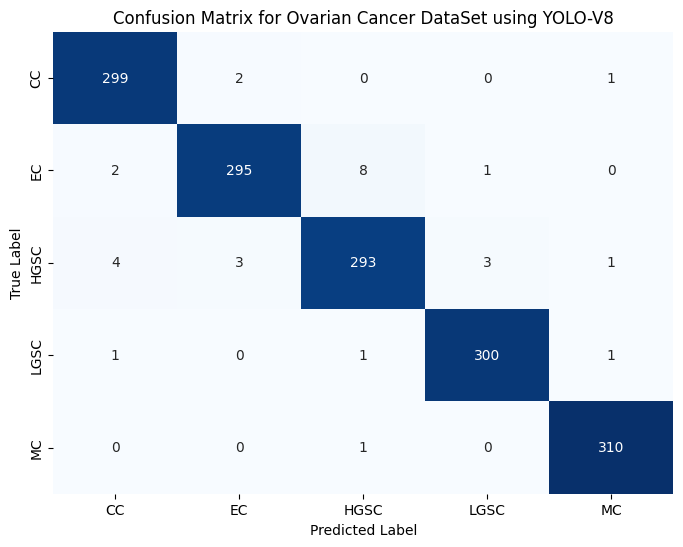

Precision: 0.980990057137257
Recall: 0.9809960681520314
F1-score: 0.9809623623507564
Accuracy: 0.9809960681520314
MCC: 0.9762597243212203


In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)
mcc = matthews_corrcoef(true_labels, predicted_labels)

class_names = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']

label_to_class = {0:'CC',1:'EC',2:'HGSC',3:'LGSC',4:'MC'}

true_labels_names = [label_to_class[label] for label in true_labels]
predicted_labels_names = [label_to_class[label] for label in predicted_labels]

conf_matrix = confusion_matrix(true_labels_names, predicted_labels_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ovarian Cancer DataSet using YOLO-V8')
plt.savefig('/content/runs/Ovarian_yolo_confusion_matrix.png')
plt.show()

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Accuracy: {accuracy}')
print(f'MCC: {mcc}')

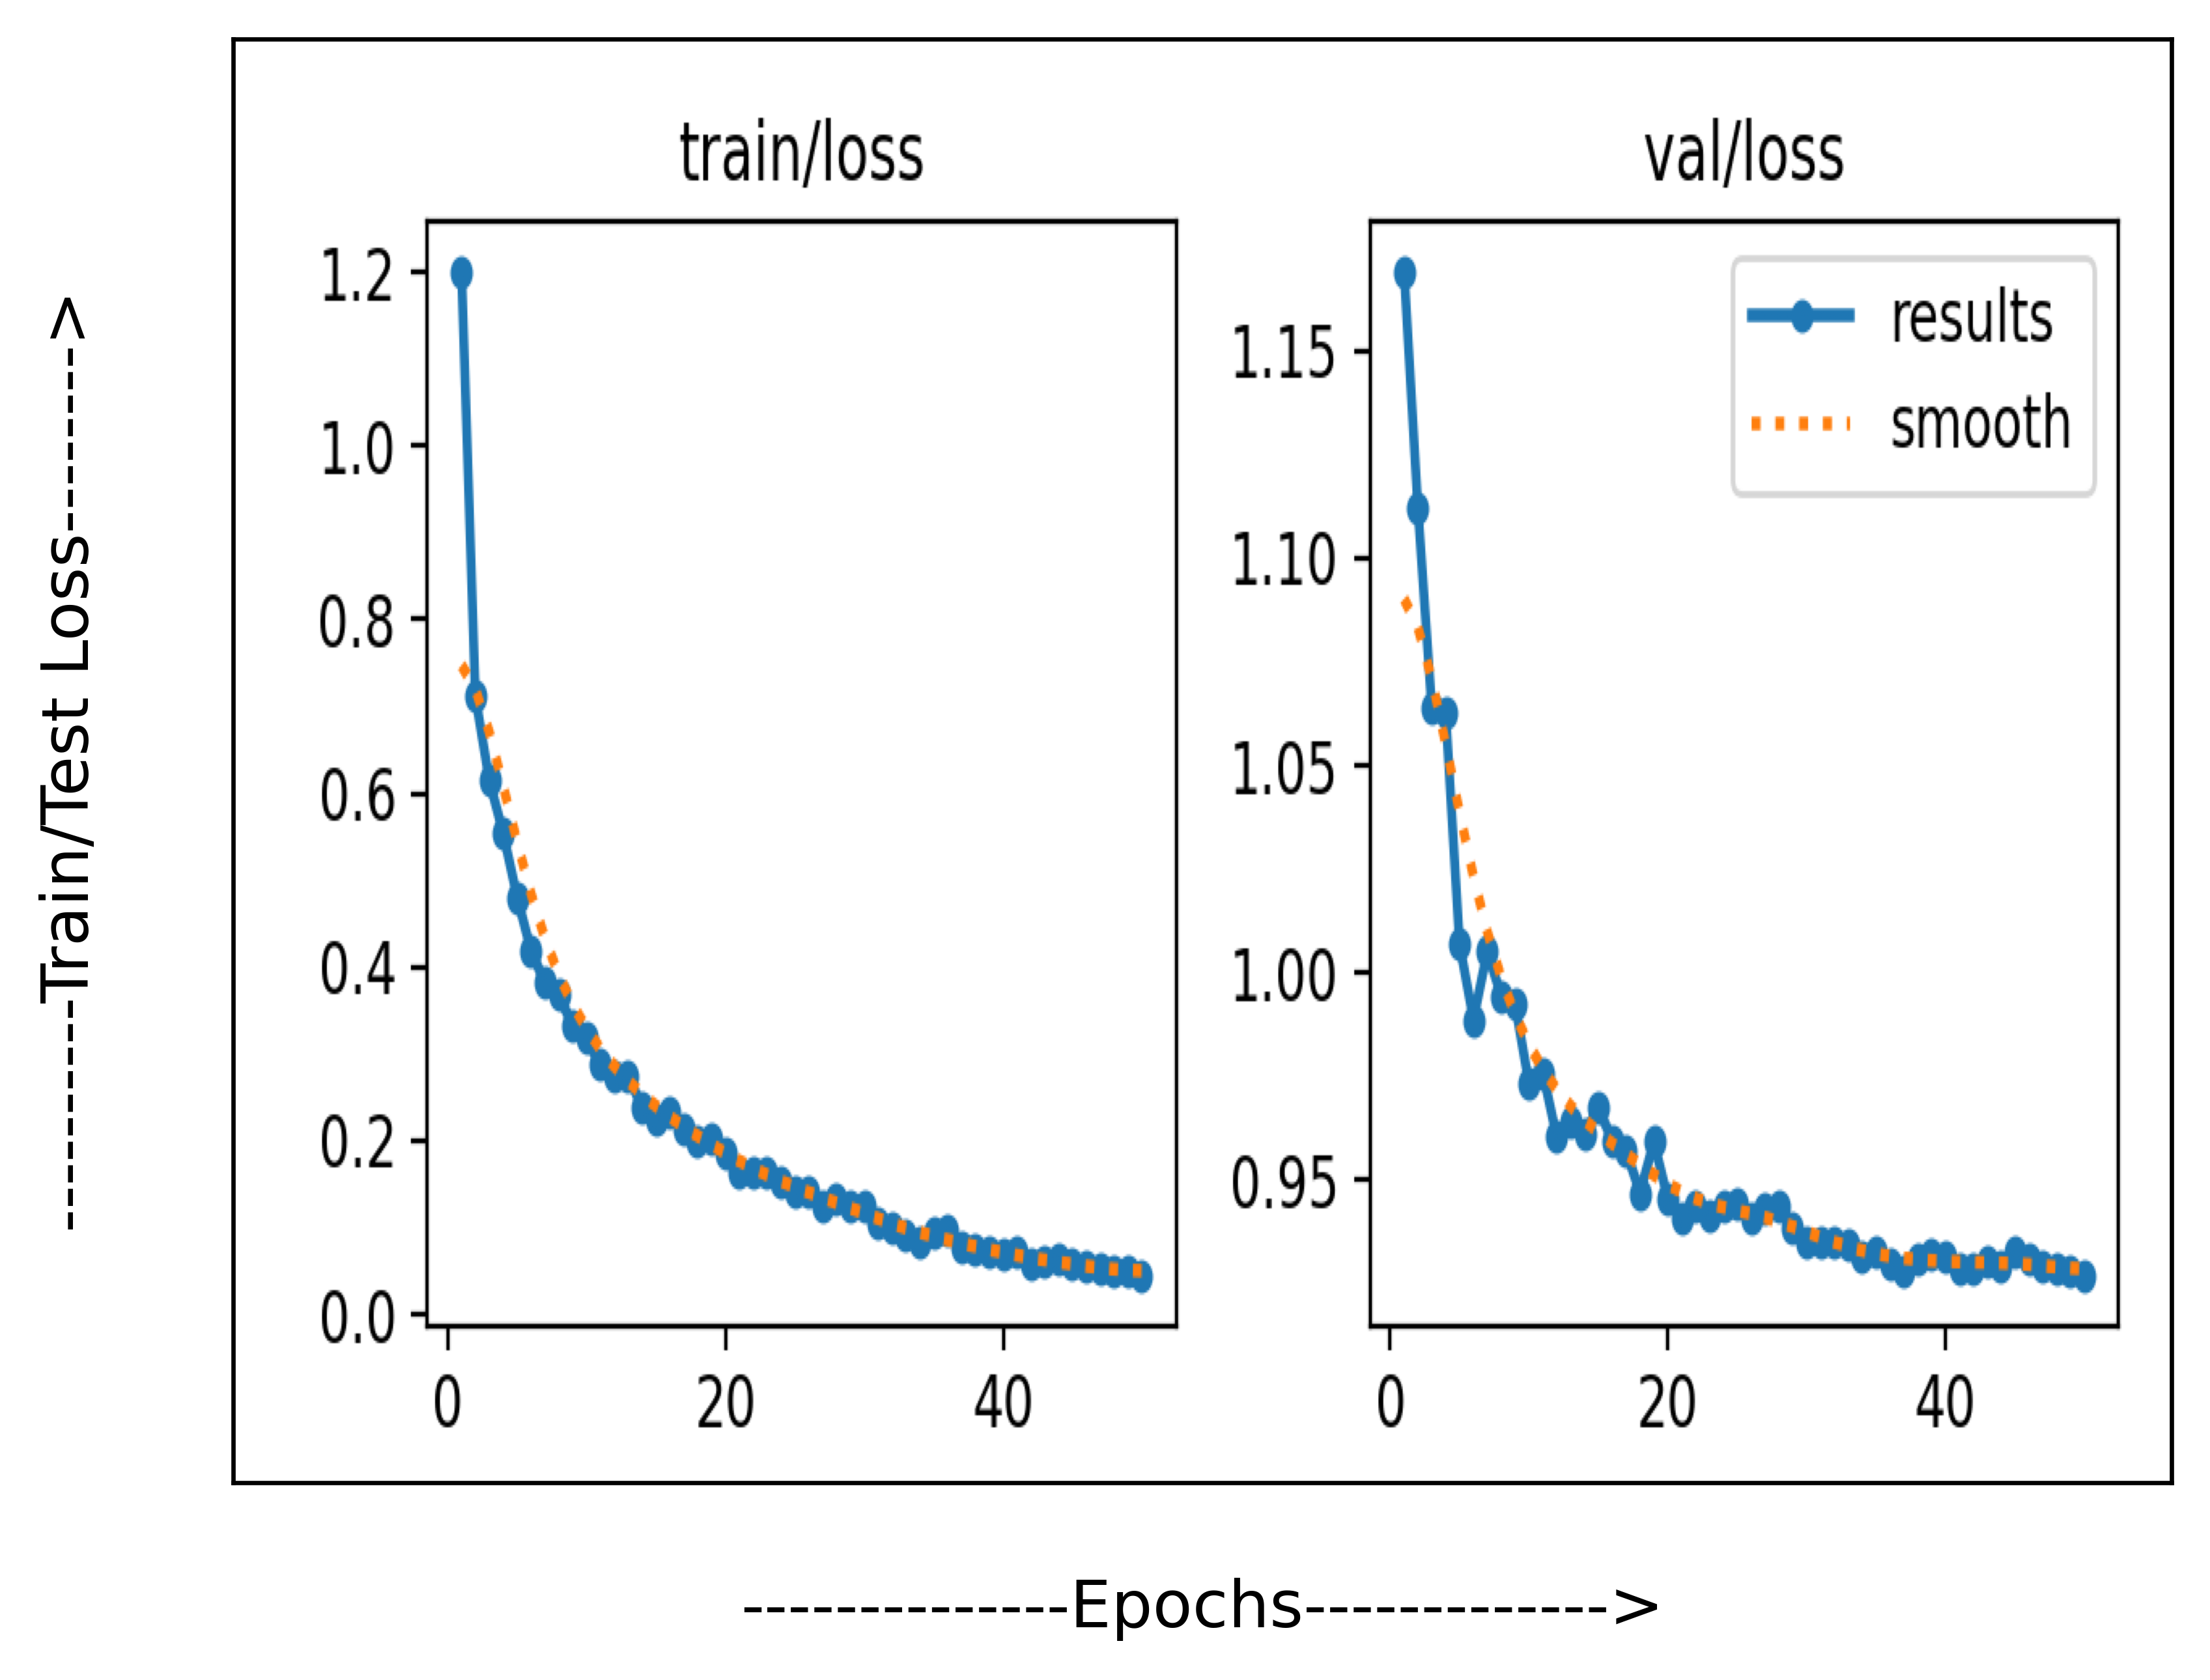

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/Yolo_Data_ovarian/image1x1.png'
image = mpimg.imread(image_path)

fig, ax = plt.subplots(dpi=600)

ax.imshow(image, aspect='auto', extent=[0, 10, 0, 10])

ax.set_xticks([])
ax.set_yticks([])

ax.text(5, -1, '--------------Epochs------------->', fontsize=12, ha='center')
ax.text(-1, 5, '----------Train/Test Loss-------->', fontsize=12, va='center', rotation=90)

ax.tick_params(axis='both', which='both', length=0)
plt.savefig('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/Yolo_Data_ovarian/classify/Loss_graph.png')
plt.show()

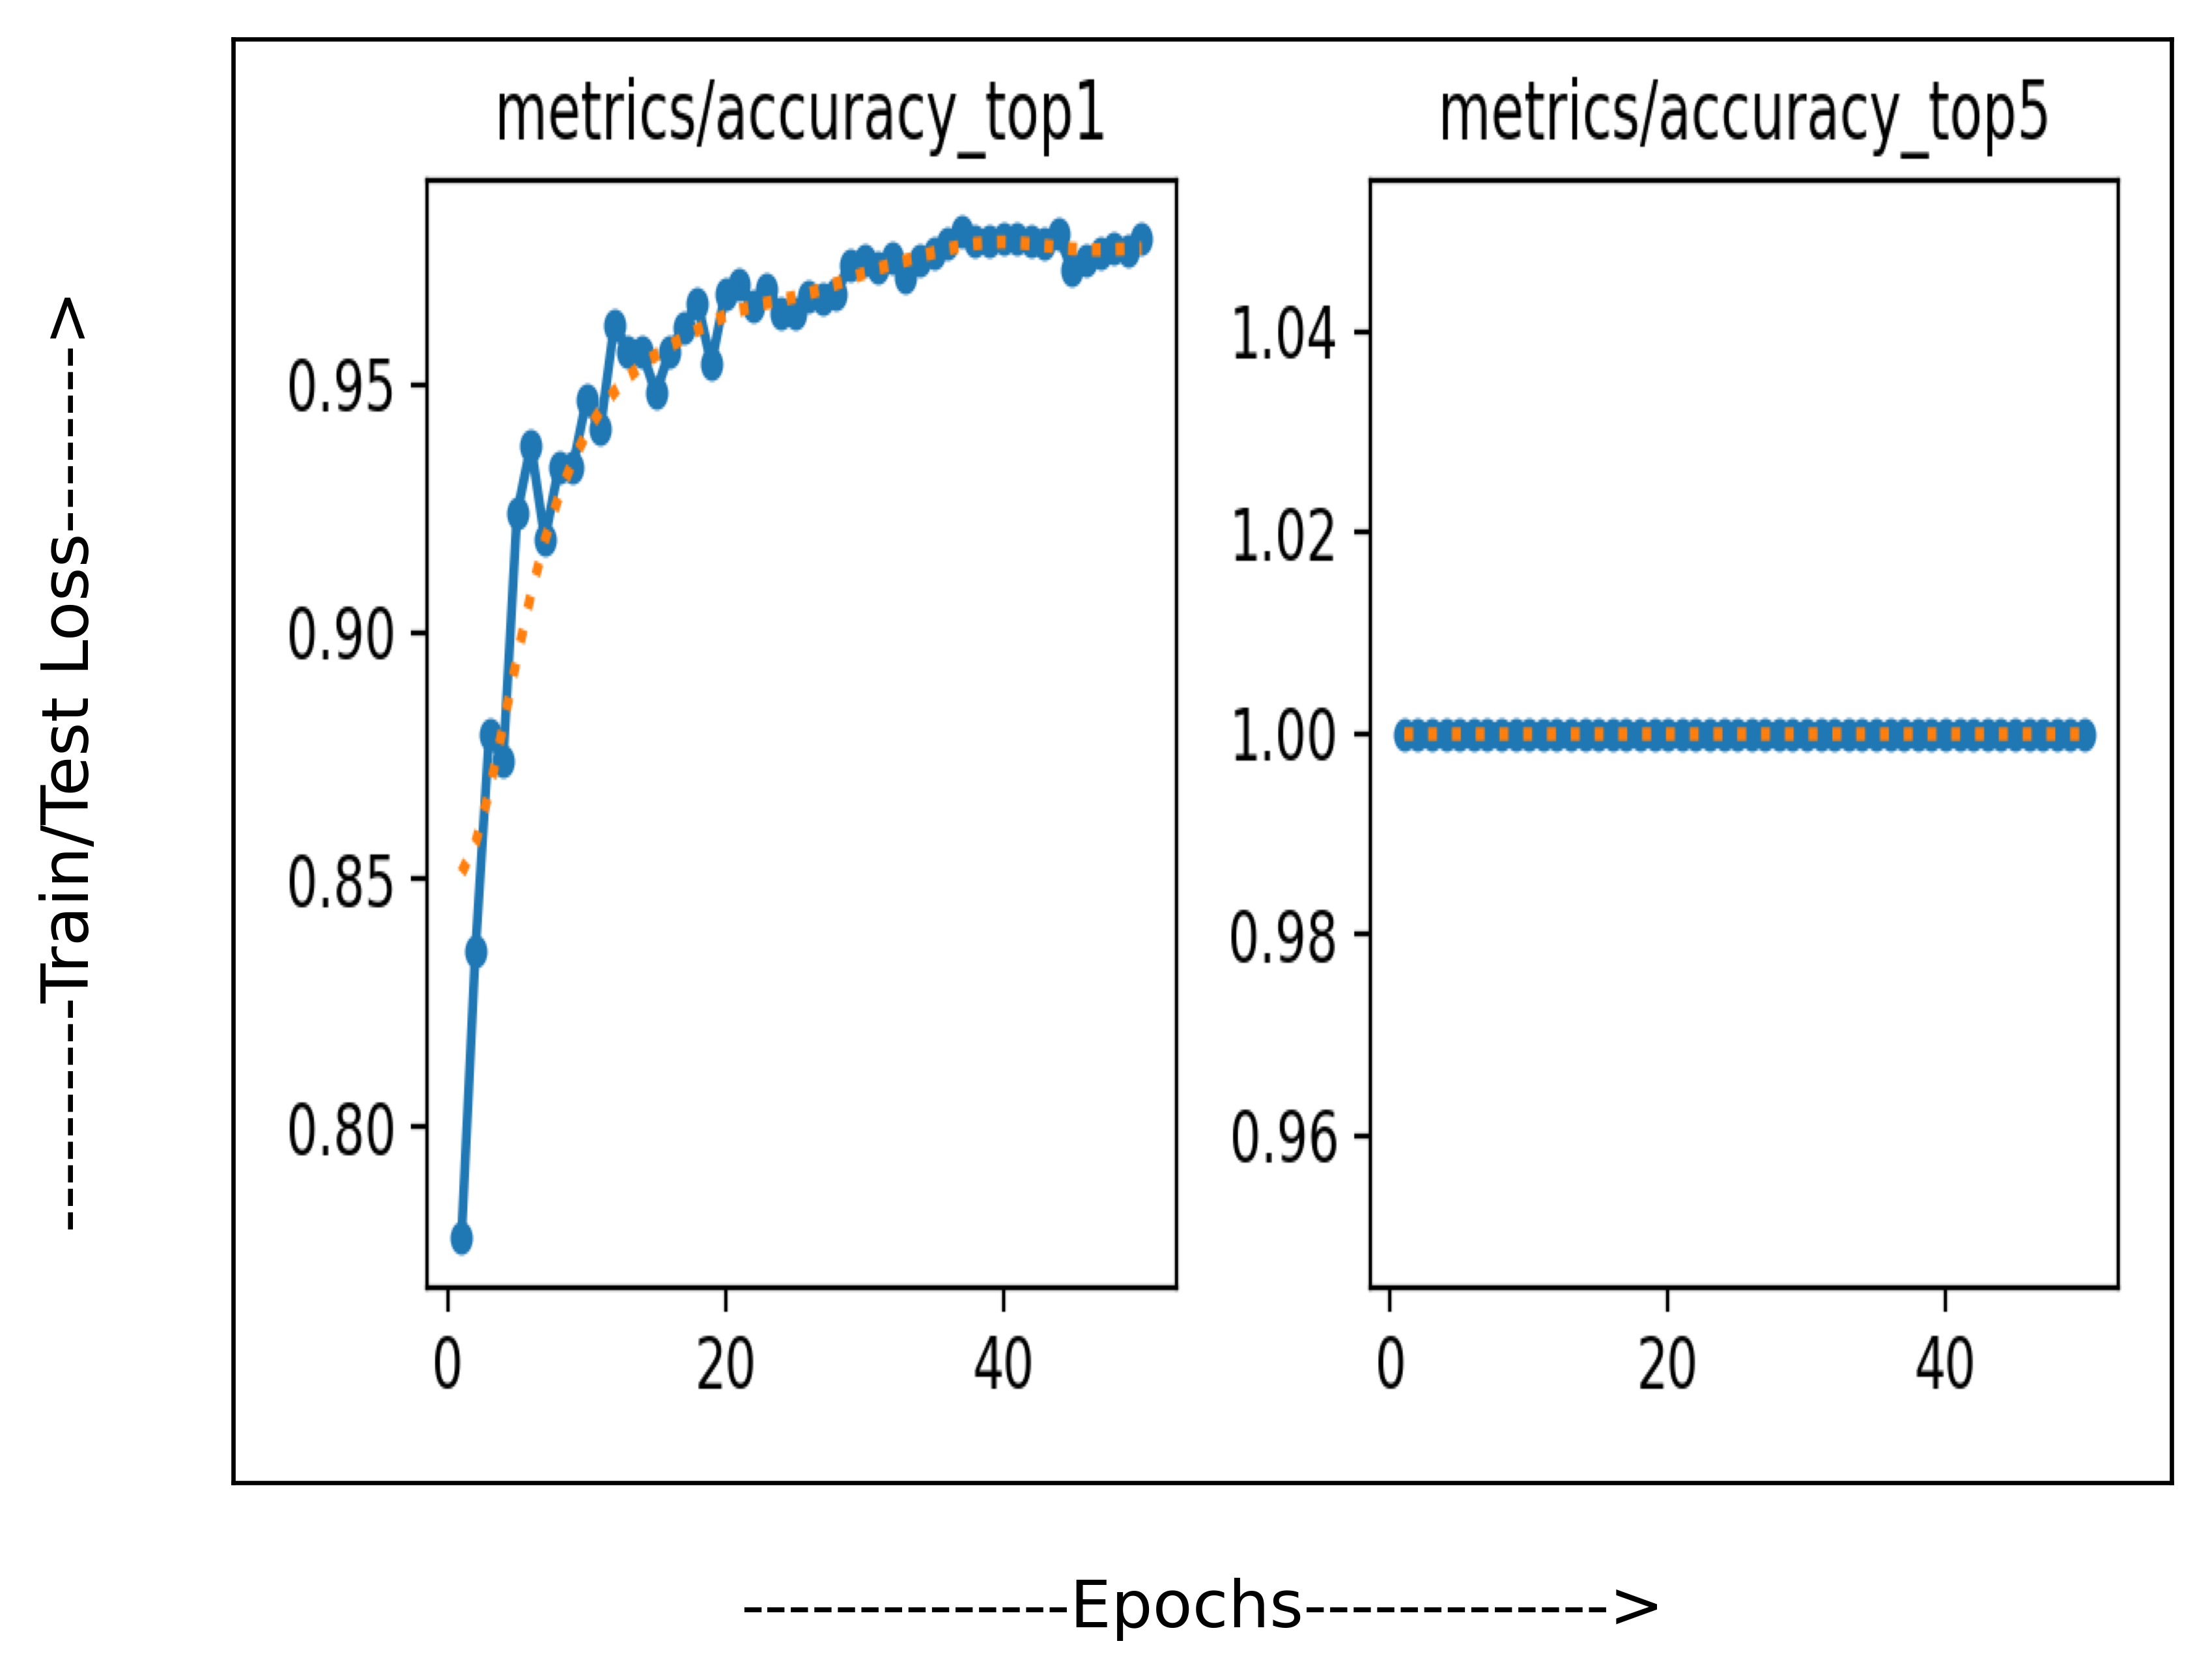

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/Yolo_Data_ovarian/image1x2.png'
image = mpimg.imread(image_path)

fig, ax = plt.subplots(dpi=600)

ax.imshow(image, aspect='auto', extent=[0, 10, 0, 10])

ax.set_xticks([])
ax.set_yticks([])

ax.text(5, -1, '--------------Epochs------------->', fontsize=12, ha='center')
ax.text(-1, 5, '----------Train/Test Loss-------->', fontsize=12, va='center', rotation=90)

ax.tick_params(axis='both', which='both', length=0)
plt.savefig('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/Yolo_Data_ovarian/classify/Accuracy_graph.png')
plt.show()

In [ ]:
# Comparison Graphs

In [5]:
import pandas as pd
dfip=pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/Inception_data_ovarian/IP_evaluation_metrics.csv')
dfmn=pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/MobileNet_Data_ovarian/Mv_evaluation_metrics.csv')
dfxp=pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/Xception_Data_ovarian/xc_data.csv')
dfyl=pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/Yolo_Data_ovarian/evaluation_metrics-yolo.csv')

In [ ]:
x=pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/trained_logs.csv')
x

,Accuracy,Precision,Recall,F1 Score,MCC
0,0.409706,0.561050,0.407974,0.376009,0.290546
1,0.350739,0.552294,0.350805,0.324351,0.235963
2,0.481773,0.481801,0.481508,0.478358,0.353548
3,0.980996,0.980990,0.980996,0.980962,0.976260


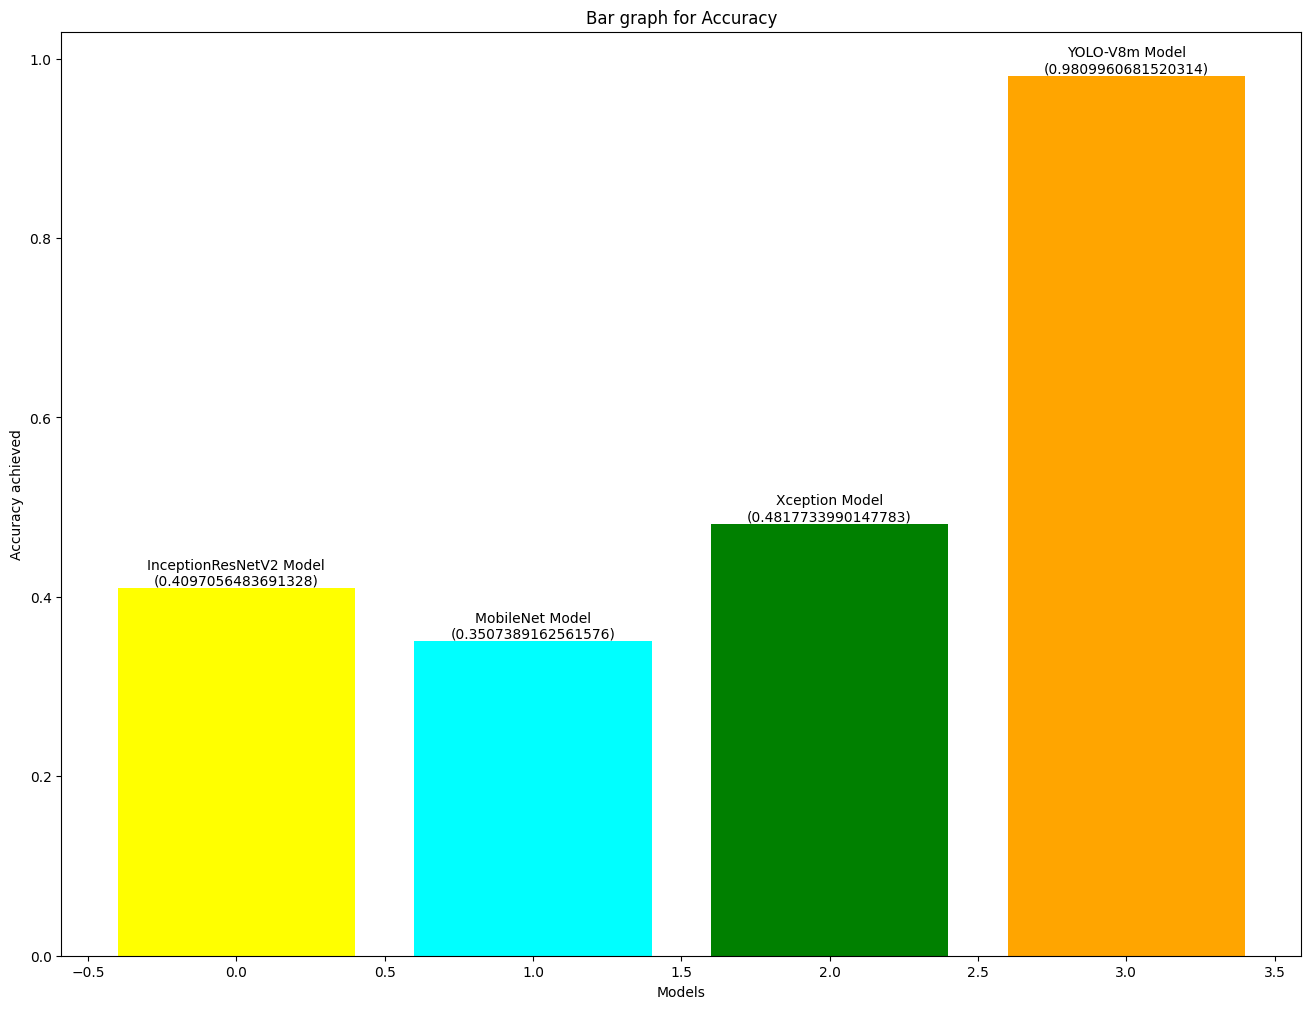

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/trained_logs.csv')

selected_column = 'Accuracy'

data_values = df[selected_column].tolist()
bar_names = ['InceptionResNetV2 Model', 'MobileNet Model', 'Xception Model', 'YOLO-V8m Model']
bar_colors = ['yellow', 'cyan', 'green', 'orange']
plt.figure(figsize=(16, 12))
bars = plt.bar(range(len(data_values)), data_values, color=bar_colors)
for bar, value, name in zip(bars, data_values, bar_names):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{name}\n({value})', ha='center', va='bottom', color='black')
plt.title(f'Bar graph for {selected_column}')
plt.xlabel('Models')
plt.ylabel('Accuracy achieved')


plt.savefig('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/bar_graph_for_accuracy.png', bbox_inches='tight')

plt.show()


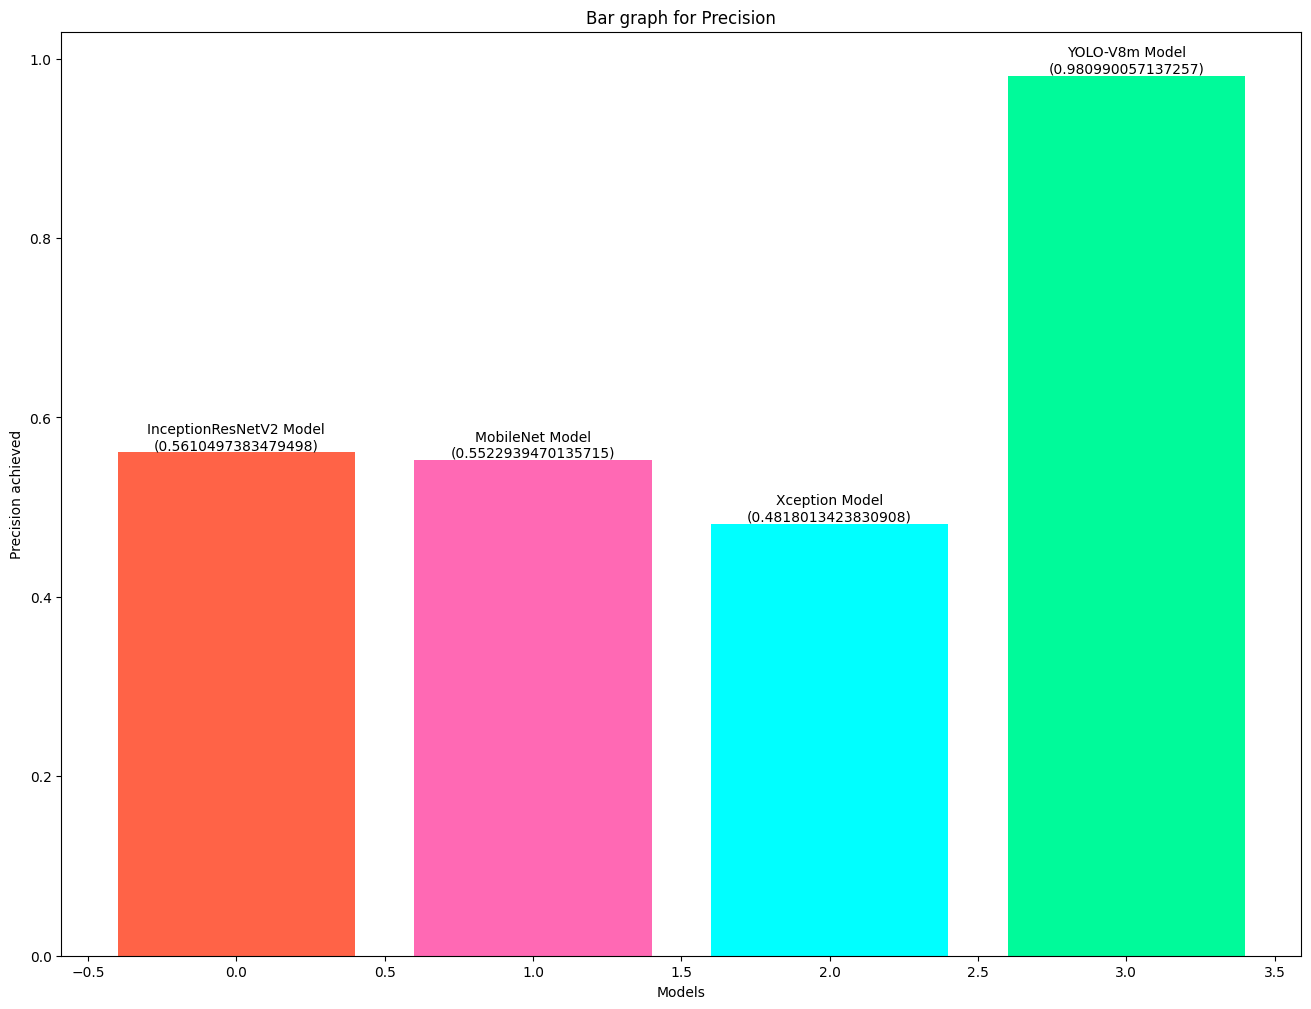

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/trained_logs.csv')

selected_column = 'Precision'

data_values = df[selected_column].tolist()
bar_names = ['InceptionResNetV2 Model', 'MobileNet Model', 'Xception Model', 'YOLO-V8m Model']
bar_colors = ['#FF6347', '#FF69B4', '#00FFFF', '#00FA9A']
plt.figure(figsize=(16, 12))
bars = plt.bar(range(len(data_values)), data_values, color=bar_colors)
for bar, value, name in zip(bars, data_values, bar_names):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{name}\n({value})', ha='center', va='bottom', color='black')
plt.title(f'Bar graph for {selected_column}')
plt.xlabel('Models')
plt.ylabel('Precision achieved')


plt.savefig('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/bar_graph_for_Precision.png', bbox_inches='tight')

plt.show()


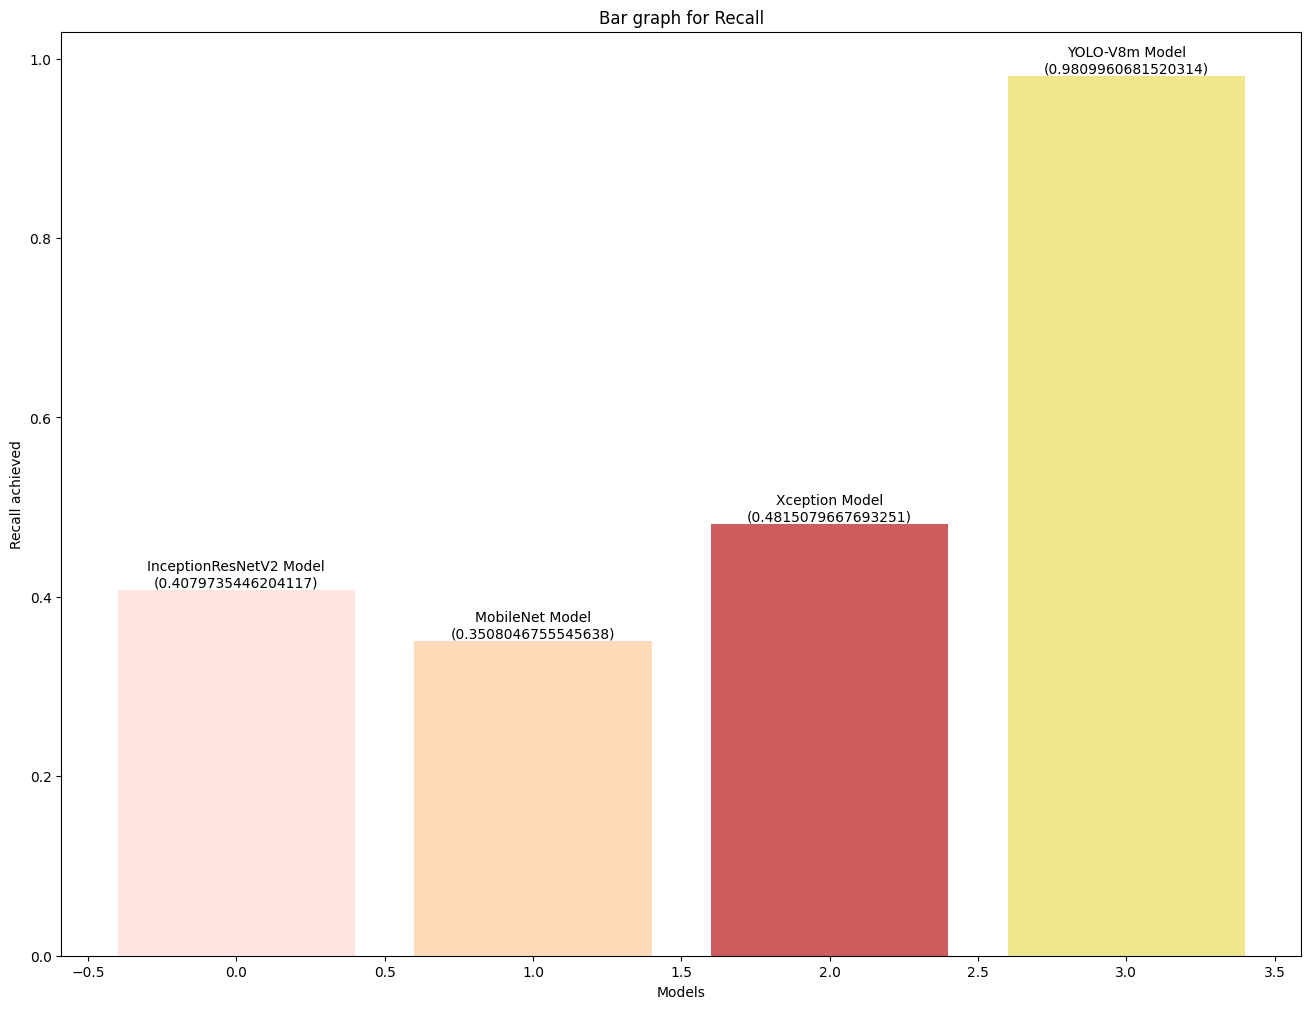

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/trained_logs.csv')

selected_column = 'Recall'

data_values = df[selected_column].tolist()
bar_names = ['InceptionResNetV2 Model', 'MobileNet Model', 'Xception Model', 'YOLO-V8m Model']
bar_colors = ['#FFE4E1', '#FFDAB9', '#CD5C5C', '#F0E68C']
plt.figure(figsize=(16, 12))
bars = plt.bar(range(len(data_values)), data_values, color=bar_colors)
for bar, value, name in zip(bars, data_values, bar_names):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{name}\n({value})', ha='center', va='bottom', color='black')
plt.title(f'Bar graph for {selected_column}')
plt.xlabel('Models')
plt.ylabel('Recall achieved')


plt.savefig('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/bar_graph_for_Recall.png', bbox_inches='tight')

plt.show()


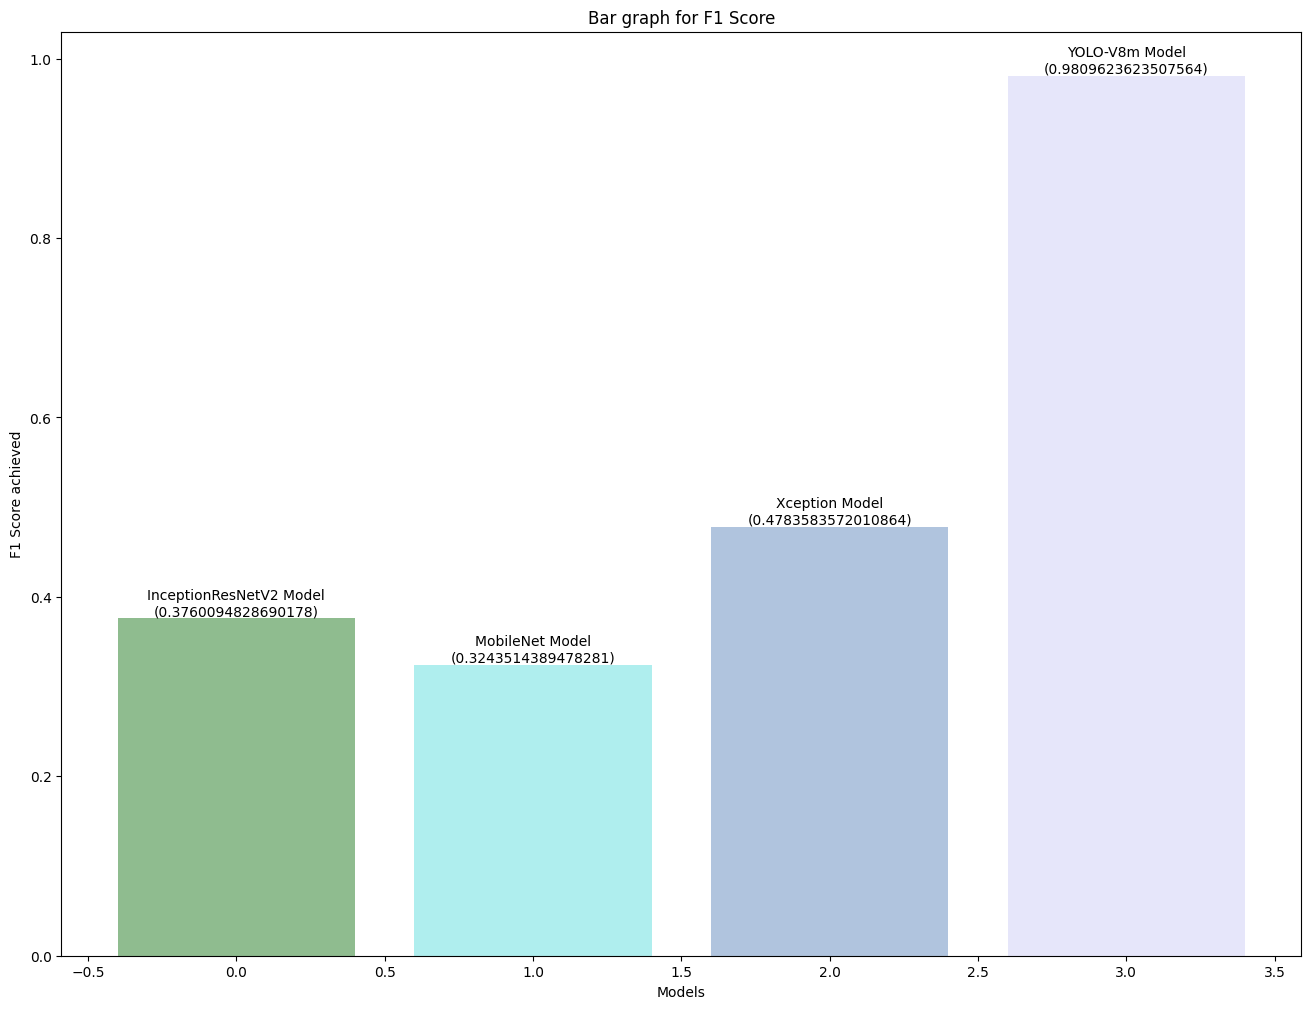

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/trained_logs.csv')

selected_column = 'F1 Score'

data_values = df[selected_column].tolist()
bar_names = ['InceptionResNetV2 Model', 'MobileNet Model', 'Xception Model', 'YOLO-V8m Model']
bar_colors = ['#8FBC8F', '#AFEEEE', '#B0C4DE', '#E6E6FA']
plt.figure(figsize=(16, 12))
bars = plt.bar(range(len(data_values)), data_values, color=bar_colors)
for bar, value, name in zip(bars, data_values, bar_names):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{name}\n({value})', ha='center', va='bottom', color='black')
plt.title(f'Bar graph for {selected_column}')
plt.xlabel('Models')
plt.ylabel('F1 Score achieved')


plt.savefig('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/bar_graph_for_F1_Score_.png', bbox_inches='tight')

plt.show()


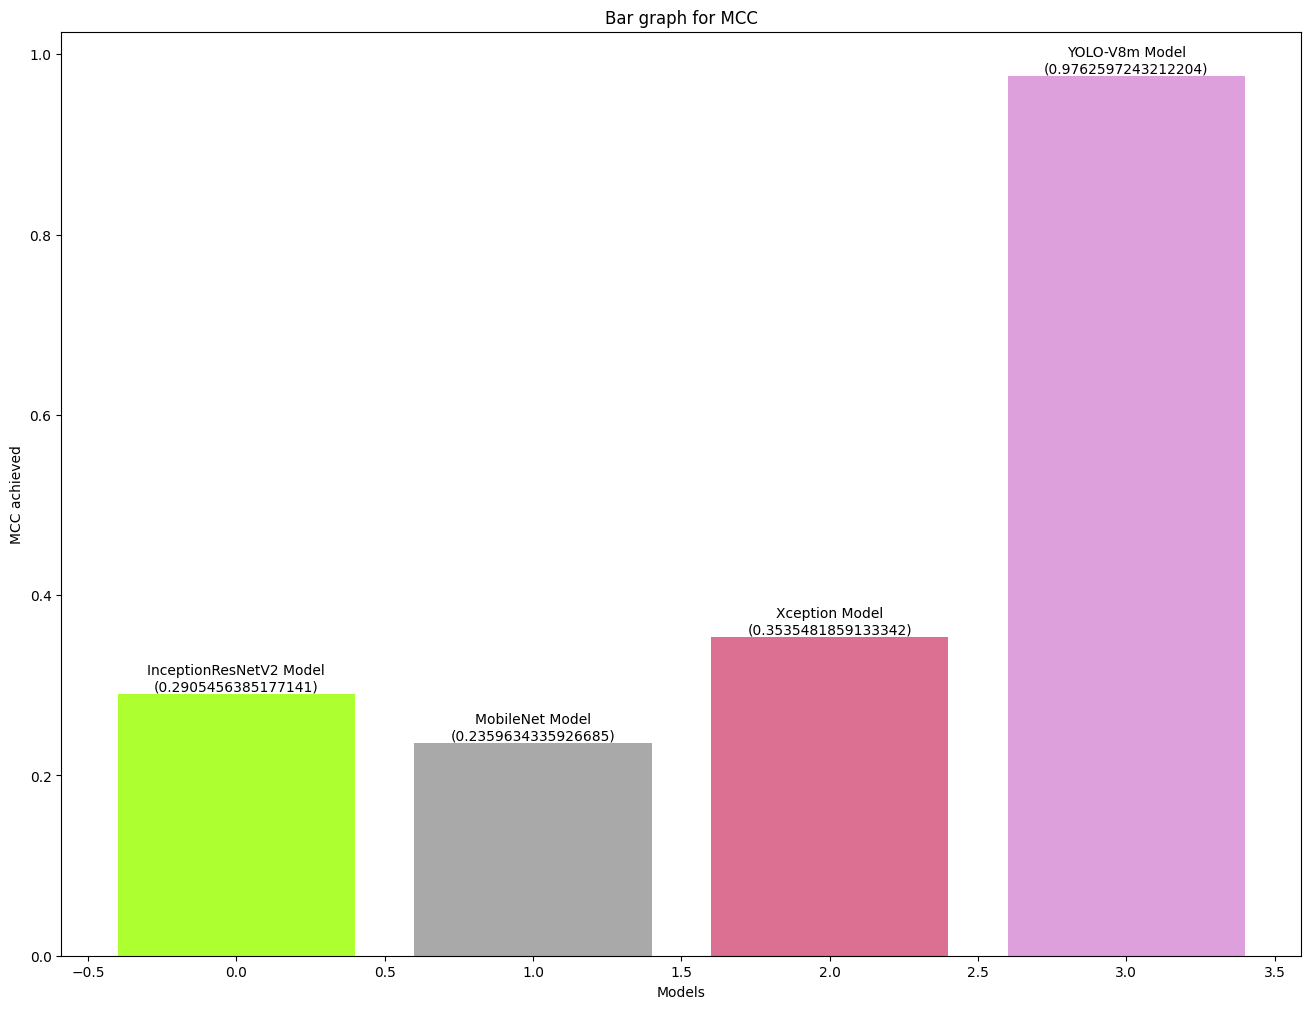

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/trained_logs.csv')

selected_column = 'MCC'

data_values = df[selected_column].tolist()
bar_names = ['InceptionResNetV2 Model', 'MobileNet Model', 'Xception Model', 'YOLO-V8m Model']
bar_colors = ['#ADFF2F', '#A9A9A9', '#DB7093', '#DDA0DD']
plt.figure(figsize=(16, 12))
bars = plt.bar(range(len(data_values)), data_values, color=bar_colors)
for bar, value, name in zip(bars, data_values, bar_names):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{name}\n({value})', ha='center', va='bottom', color='black')
plt.title(f'Bar graph for {selected_column}')
plt.xlabel('Models')
plt.ylabel('MCC achieved')


plt.savefig('/content/drive/MyDrive/Datasets_Ovarian/Ovarian_Train_Logs/bar_graph_for_MCC_.png', bbox_inches='tight')

plt.show()
